In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Matrix factorization through vanilla SCA

In [26]:
def MF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L))
    W = np.ones((L,n))

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)

    for _ in tqdm(range(max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [27]:
A = np.random.normal(size = (15,20))
A /= np.linalg.norm(A, axis = 0)

In [28]:
(V,W), D = MF_SCA(A,10)

  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

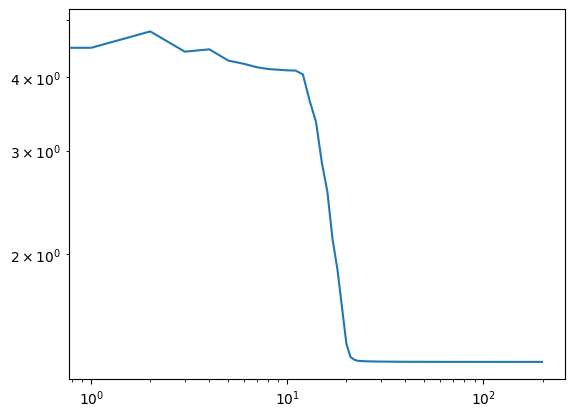

In [21]:
plt.loglog(D)

In [22]:
np.linalg.norm(V @ W - A, ord='fro')

1.3135699685845301